In [58]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import itertools

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

from scipy.sparse.linalg import norm, svds

%matplotlib inline
import matplotlib.pyplot as plt

from df_builder_mini_cleaner import *
from word_counts import *




# Creating the DataFrame

In [2]:
cnn_df = pd.read_csv('data/cnn.csv')
fox_df = pd.read_csv('data/fox.csv')
onion_df = pd.read_csv('data/onion_csv.csv')

In [3]:
df_final = build_df(onion_df, fox_df, cnn_df)

In [4]:
df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney general’s b...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pet’s alle...,1,0,0


# Word Count

In [5]:
onion_word_count = word_count(list(df_final.Article[0:4927]))

In [6]:
cnn_word_count = word_count(list(df_final.Article[4927:9927]))

In [7]:
fox_word_count = word_count(list(df_final.Article[9927:]))

In [8]:
word_counts_df = pd.DataFrame([['Onion', onion_word_count], ['CNN', cnn_word_count], ['Fox', fox_word_count]], columns=['Source', 'Average_Word_Count'])

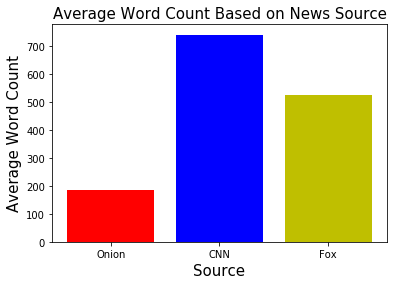

In [9]:
word_count_graph(word_counts_df)

### More Cleaning

In [14]:
def new_cleaner(df):
    '''
    Removes more features like punctuation and words that
    should not be in there
    Input: df_final
    output: df_final with cleaned articles
    '''
    article_list = list(df_final.Article)
    clean_list = []
    for article in article_list:
        samp1 = re.sub('[''\”\“\‘;:\'\'\'•·%$!&+}{|><_…/\’*0123456789\`]', '', article)
        samp2 = re.sub('[-—]', ' ', samp1)
        samp3 = samp2.replace('news','')
        clean_list.append(samp3.replace('fox',''))
    df['Article'] = clean_list
    return df

In [15]:
new_df_final = new_cleaner(df_final)

In [16]:
new_df_final

,Article,Satire,CNN,Fox
0,washington in a statement confirming his suppo...,1,0,0
1,washington irked that the attorney generals br...,1,0,0
2,stamford ct lamenting that the numbers were mu...,1,0,0
3,nairobi kenya warning that a complete overhaul...,1,0,0
4,napa ca after being lovingly tended by generat...,1,0,0
5,pineville la citing concerns over historically...,1,0,0
6,cambridge ma warning that nothing was more dan...,1,0,0
7,south bend in stumbling through the restaurant...,1,0,0
8,heaven speaking with obvious nostalgia regardi...,1,0,0
9,cary nc competing to secure the new pets alleg...,1,0,0


# Models

### Tokenizing and Stemming

In [17]:
def tokenize(doc):
    return [porter.stem(word) for word in word_tokenize(doc)]

In [18]:
test_stop_words = ['serious','any', 'ours', 'go', 'do', 'else', 'while', 'somehow', 'seem', 'front', 'thick', 'once', 'system',
 'latter', 'amongst', 'hence', 'un', 'cannot', 'more', 'eight', 'he', 'seems', 'it', 'hereafter', 'last', 'here',
 'beyond', 'because', 'few', 'fill', 'his', 'further', 'sincere', 'their', 'made', 'fifty', 'whatever', 'whenever', 'been', 'describe', 'otherwise',
 'or', 'our', 'move', 'eg', 'over', 'per', 'amoungst', 'perhaps', 'you', 'beside', 'hundred', 'across',
 'which', 'where', 'anyone', 'anywhere', 'name', 'several', 'a', 'no', 'whence', 'mostly', 'so', 'call',
 'seemed', 'everyone', 'these', 'besides', 'whom', 'whereby', 'eleven', 'thereupon', 'twelve', 'when', 'former', 'most',
 'therein', 'had', 'hasnt', 'yourself', 'next', 'being', 'wherein', 'only', 'them', 'third', 'mine', 'show',
 'nobody', 'sometimes', 'somewhere', 'still', 'were', 'with', 'became', 'how', 'yourselves', 'her', 'much',
 'ltd', 'as', 'those', 'done', 'twenty', 'along', 'get', 'herself', 'interest', 'nor', 'however', 'same', 'side', 'whole', 'namely', 'might',
 'if', 'has', 'up', 'both', 'not', 'bottom', 'ourselves', 'via', 'whither', 'fifteen', 'your', 'mill',
 'someone', 'even', 'please', 'thus', 'under', 'are', 'in', 'etc', 'anyhow', 'after', 'hereupon', 'my', 'from',
 'through', 'before', 'own', 'against', 'below', 'throughout', 'although', 'herein', 'himself', 'noone', 'will',
 'also', 'thru', 'out', 'keep', 'something', 'there', 'nevertheless', 'nine', 'always', 'except', 'almost', 'some',
 'couldnt', 'hereby', 'indeed', 'detail', 'moreover', 'hers', 're', 'all', 'six', 'themselves', 'two', 'already', 'forty',
 'thereby', 'become', 'each', 'thence', 'within', 'nowhere', 'by', 'due', 'full', 'thin', 'us', 'anyway', 'other', 'among', 'this',
 'though', 'without', 'then', 'five', 'another', 'first', 'myself', 'every', 'at', 'de', 'toward', 'whereafter',
 'alone', 'beforehand', 'amount', 'ie', 'meanwhile', 'behind', 'must', 'now', 'others', 'many', 'be', 'con', 'an', 'formerly',
 'everywhere', 'therefore', 'find', 'to', 'together', 'could', 'elsewhere', 'about', 'three', 'am', 'since', 'me',
 'whose', 'ever', 'cry', 'becoming', 'whereas', 'see', 'well', 'back', 'everything', 'nothing', 'whether', 'itself', 'whoever', 'often', 'never', 'down', 'top', 'least', 'too',
 'of', 'during', 'inc', 'less', 'that', 'she', 'give', 'than', 'latterly', 'they', 'fire', 'found', 'the',
 'bill', 'thereafter', 'enough', 'very', 'have', 'its', 'who', 'anything', 'afterwards', 'around', 'upon',
 'but', 'either', 'again', 'should', 'what', 'into', 'none', 'would', 'can', 'for', 'put', 'empty', 'why', 'is', 'him', 'above', 'between', 'four', 'off',
 'cant', 'may', 'sometime', 'until', 'and', 'part', 'yet', 'onto', 'towards', 'neither', 'yours',
 'we', 'take', 'rather', 'on', 'such', 'was', 'ten', 'becomes', 'co', 'one', 'i', 'seeming', 'wherever', 'whereupon', 'sixty','ad']

In [88]:
def tokenize2(doc):
    '''
    Tokenization function for the TFIDF vectorizor
    input: string of article
    output: list of article tokens that have been stemmed
    '''
    # Tokenizes each word in the document
    tokens = word_tokenize(doc)
    # Defines an empty list to append the stemmed words to
    cleaned_docs = []
    # Creates PorterStemmer object
    porter = PorterStemmer()
    # For loop to iterate through tokens in document
    for word in tokens:
    # Removes tokens that are just one character
        if len(word) < 2:
            tokens.remove(word)
    # Removes stop words from articles that are in test_stop_words 
    # list and appends porter stemmed words to the cleaned doc list
        else:
            if word not in test_stop_words:
                cleaned_docs.append(porter.stem(word))
    # Returns list of tokens
    return cleaned_docs
    

### Train Test Split

In [22]:
docs_train, docs_test, y_train, y_test = train_test_split(new_df_final['Article'], new_df_final['Satire'])

### TFIDF Vectorization 

In [23]:
# cust_stop_words = ['serious', 'any', 'ours', 'go', 'do','else', 'while', 'somehow', 'seem', 'front', 'thick', 'once', 'system', 'latter', 'amongst', 'hence', 'un',
#  'cannot', 'more', 'eight', 'he', 'seems', 'it', 'hereafter', 'last', 'here', 'beyond', 'because', 'few', 'fill',
#  'his', 'further', 'sincere', 'their', 'made', 'fifty', 'whatever', 'whenever', 'been', 'describe', 'otherwise', 'or',
#  'our', 'move', 'eg', 'over', 'per', 'amoungst', 'perhaps', 'you', 'beside', 'hundred', 'across', 'which',
#  'where', 'anyone', 'anywhere', 'name', 'several', 'a', 'no', 'whence', 'mostly', 'so', 'call', 'seemed', 'everyone',
#  'these', 'besides', 'whom', 'whereby', 'eleven', 'thereupon', 'twelve', 'when', 'former', 'most', 'therein', 'had',
#  'hasnt', 'yourself', 'next', 'being', 'wherein', 'only', 'them', 'third', 'mine', 'show', 'nobody',
#  'sometimes', 'somewhere', 'still', 'were', 'with', 'became', 'how', 'yourselves', 'her', 'much', 'ltd', 'as', 'those',
#  'done', 'twenty', 'along', 'get', 'herself', 'interest', 'nor', 'however', 'same', 'side', 'whole', 'namely',
#  'might', 'if', 'has', 'up', 'both', 'not', 'bottom', 'ourselves', 'via', 'whither', 'fifteen', 'your', 'mill', 'someone', 'even',
#  'please', 'thus', 'under', 'are', 'in', 'etc', 'anyhow', 'after', 'hereupon', 'my', 'from', 'through', 'before', 'own', 'against', 'below', 'throughout', 'although', 'herein',
#  'himself', 'noone', 'will', 'also', 'thru', 'out', 'keep', 'something', 'there', 'nevertheless', 'nine', 'always',
#  'except', 'almost', 'some', 'couldnt', 'hereby', 'indeed', 'detail', 'moreover', 'hers', 're', 'all', 'six',
#  'themselves', 'two', 'already', 'forty', 'thereby', 'become', 'each', 'thence', 'within', 'nowhere', 'by', 'due', 'full', 'thin', 'us', 'anyway', 'other', 'among', 'this', 'though', 'without', 'then', 'five', 'another', 'first', 'myself', 'every', 'at', 'de', 'toward',
# 'whereafter', 'alone', 'beforehand', 'amount', 'ie', 'meanwhile', 'behind', 'must', 'now', 'others',
#  'many', 'be', 'con', 'an', 'formerly', 'everywhere', 'therefore', 'find', 'to', 'together', 'could', 'elsewhere', 'about', 'three', 'am', 'since', 'me', 'whose', 'ever', 'cry', 'becoming', 'whereas', 'see', 'well', 'back', 'everything', 'nothing', 'whether', 'itself',
#  'whoever', 'often', 'never', 'down', 'top', 'least', 'too', 'of', 'during', 'inc', 'less', 'that', 'she', 'give', 'than',
#  'latterly', 'they', 'fire', 'found', 'the', 'bill', 'thereafter', 'enough', 'very', 'have', 'its', 'who', 'anything',
#  'afterwards', 'around', 'upon', 'but', 'either', 'again', 'should', 'what', 'into', 'none', 'would', 'can', 'for', 'put', 'empty', 'why', 'is', 'him',
#  'above', 'between', 'four', 'off', 'cant', 'may', 'sometime', 'until', 'and', 'part', 'yet', 'onto', 'towards','neither',
#  'yours', 'we', 'take', 'rather', 'on', 'such', 'was', 'ten', 'becomes', 'co', 'one', 'i', 'seeming', 'wherever','whereupon','sixty','abov', 'afterward', 
# 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els',
# 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr',
# 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 
# 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth',
# 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 
# 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv','anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh','ad']

In [89]:
vect = TfidfVectorizer(tokenizer=tokenize2, min_df=3)
X_train = vect.fit_transform(docs_train)
X_test = vect.transform(docs_test)

### Logistic Regression Model

In [90]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/Users/jphooster22/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [91]:
log_reg_y_pred = log_reg.predict(X_test)
log_reg_con_mat = confusion_matrix(y_test, log_reg_y_pred)
recall_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[1,0])
prec_log_reg = log_reg_con_mat[1,1]/(log_reg_con_mat[1,1]+log_reg_con_mat[0,1])
F1_log_reg = ((prec_log_reg*recall_log_reg)/(prec_log_reg+recall_log_reg))*2
F1_log_reg

0.9648033126293997

In [ ]:
log_reg.predict()

### Naive Bayes Model

In [140]:
na_ba_1 = MultinomialNB(alpha=1)
na_ba_1.fit(X_train, y_train)

na_ba = MultinomialNB(alpha=.1)
na_ba.fit(X_train, y_train)

na_ba_0 = MultinomialNB(alpha=.0001)
na_ba_0.fit(X_train, y_train)


MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

#### Naive Bayes alpha = 1

In [141]:
na_ba_1_pred = na_ba_1.predict(X_test)
na_ba_1_con_mat = confusion_matrix(y_test, na_ba_1_pred)
recall_na_ba_1= na_ba_1_con_mat[1,1]/(na_ba_1_con_mat[1,1]+na_ba_1_con_mat[1,0])
prec_na_ba_1 = na_ba_1_con_mat[1,1]/(na_ba_1_con_mat[1,1]+na_ba_1_con_mat[0,1])
F1_na_ba_1 = ((prec_na_ba_1*recall_na_ba_1)/(prec_na_ba_1+recall_na_ba_1))*2
F1_na_ba_1

0.8099250936329588

#### Naive Bayes alpha = .1

In [136]:
na_ba_pred = na_ba.predict(X_test)
na_ba_con_mat = confusion_matrix(y_test, na_ba_pred)
recall_na_ba= na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[1,0])
prec_na_ba = na_ba_con_mat[1,1]/(na_ba_con_mat[1,1]+na_ba_con_mat[0,1])
F1_na_ba = ((prec_na_ba*recall_na_ba)/(prec_na_ba+recall_na_ba))*2
F1_na_ba

0.8695286195286196

#### Naive Bayes alpha = .0001

In [137]:
na_ba_0_pred = na_ba_0.predict(X_test)
na_ba_0_con_mat = confusion_matrix(y_test, na_ba_0_pred)
recall_na_ba_0= na_ba_0_con_mat[1,1]/(na_ba_0_con_mat[1,1]+na_ba_0_con_mat[1,0])
prec_na_ba_0 = na_ba_0_con_mat[1,1]/(na_ba_0_con_mat[1,1]+na_ba_0_con_mat[0,1])
F1_na_ba_0 = ((prec_na_ba_0*recall_na_ba_0)/(prec_na_ba_0+recall_na_ba_0))*2
F1_na_ba_0

0.8535714285714285

# Data Vis for Models

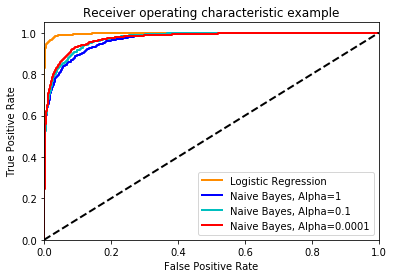

In [143]:
roc_log_reg  = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1], pos_label=1)

roc_na_ba_1  = roc_curve(y_test, na_ba_1.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba  = roc_curve(y_test, na_ba.predict_proba(X_test)[:,1], pos_label=1)
roc_na_ba_0  = roc_curve(y_test, na_ba_0.predict_proba(X_test)[:,1], pos_label=1)


plt.figure()
lw = 2
plt.plot(roc_log_reg[0], roc_log_reg[1], color='darkorange',
         lw=lw, label='Logistic Regression')

plt.plot(roc_na_ba_1[0], roc_na_ba_1[1], color='b',
         lw=lw, label='Naive Bayes, Alpha=1')
plt.plot(roc_na_ba[0], roc_na_ba[1], color='c',
         lw=lw, label='Naive Bayes, Alpha=0.1')
plt.plot(roc_na_ba_0[0], roc_na_ba_0[1], color='r',
         lw=lw, label='Naive Bayes, Alpha=0.0001')


plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [95]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[2305   22]
 [  63 1165]]


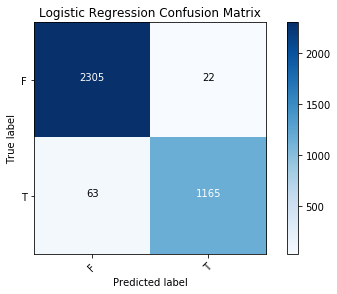

In [96]:
plot_confusion_matrix(log_reg_con_mat,['F','T'], title='Logistic Regression Confusion Matrix')

Confusion matrix
[[2212  115]
 [ 195 1033]]


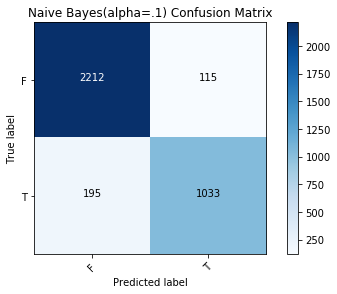

In [97]:
plot_confusion_matrix(na_ba_con_mat,['F','T'], title='Naive Bayes(alpha=.1) Confusion Matrix')

# Feature Exploration

In [98]:
features = vect.get_feature_names()

log_reg_coef = log_reg.coef_.reshape(log_reg.coef_.shape[1],)

In [99]:
log_reg.coef_.shape[1]

19989

In [100]:
len(features), len(log_reg_coef)

(19989, 19989)

In [101]:
feature_df = pd.DataFrame(features)

In [102]:
feature_df

,0
0,''
1,``
2,aa
3,aaa
4,aamaq
5,aaron
6,aarp
7,ab
8,abaaoud
9,ababa


In [103]:
feature_df['Beta_Coef'] = log_reg_coef
feature_df['Word'] = feature_df[0]

In [104]:
beta_feature_df = feature_df[['Beta_Coef', 'Word']]

In [105]:
sort = beta_feature_df.sort_values('Beta_Coef')

In [106]:
sort

,Beta_Coef,Word
15284,-6.158516,said
18198,-4.993054,trump
17928,-4.266663,told
123,-4.078771,accord
13500,-3.776810,polic
8663,-3.021781,includ
13109,-2.983709,peopl
3275,-2.875353,clinton
1064,-2.819561,attack
18297,-2.714163,twitter


In [107]:
#word_searching = list(sort.Word)

In [108]:
# short_words = []
# for word in word_searching:
#     if len(word) < 3:
#         short_words.append(word)

In [109]:
bot_10=list(sort['Beta_Coef'][0:10])
top_10=list(sort['Beta_Coef'][-10:])
bot_top = bot_10 +top_10

In [110]:
bot_10_words = list(sort['Word'][0:10])
top_10_words = list(sort['Word'][-10:])
top_bot_words = bot_10_words + top_10_words

Text(0.5, 0, 'Word')

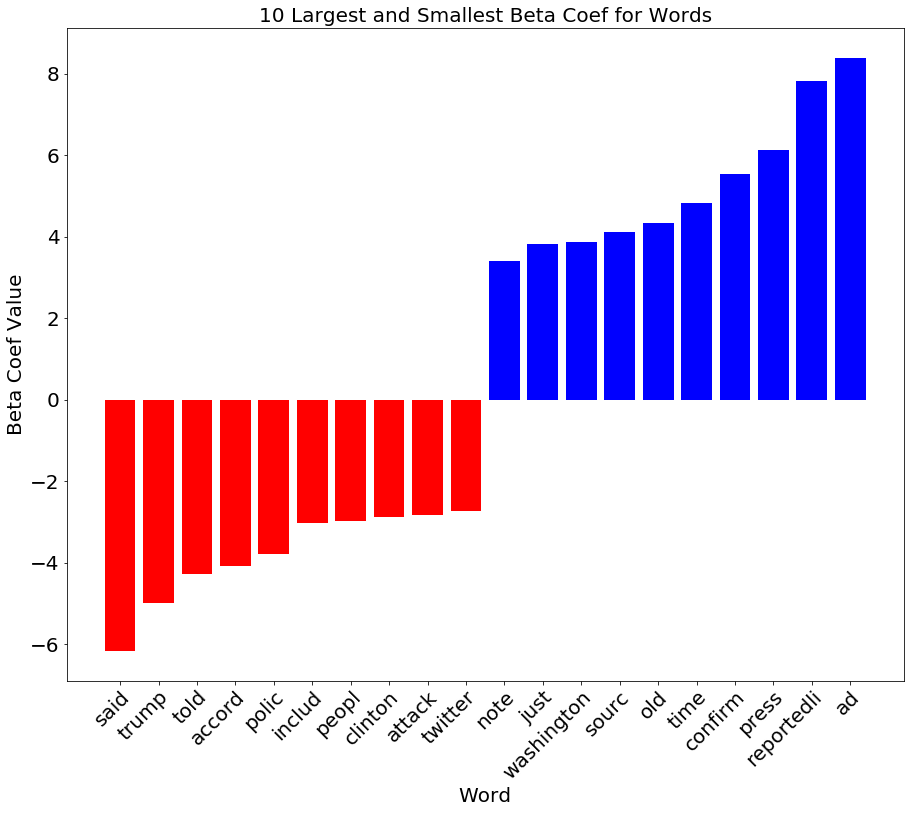

In [111]:
data = bot_top
labels = top_bot_words
fig, ax = plt.subplots(figsize=(15,12))

plt.bar(np.arange(len(data)), data, color = 'rrrrrrrrrrbbbbbbbbbb')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, fontsize =20, ha='right', rotation_mode='anchor')
plt.setp( ax.yaxis.get_majorticklabels(), fontsize = 20)
ax.set_xticklabels(labels)
ax.set_title("10 Largest and Smallest Beta Coef for Words", fontsize = 20)
ax.set_ylabel("Beta Coef Value", fontsize = 20)
ax.set_xlabel("Word", fontsize = 20)

With out stemming adding is one of the most important words, so left ad in there

### Average Magnitude of TFIDF Vector for Satire and News

In [112]:
def avg_tfidf_mag(X_train_vect, y_train):
    '''
    Calculates the average magnitude of the TFIDF vector for Satire and News 
    categories
    input: sparse matrix for training
    '''
    row_norms=[]
    for row in X_train:
        row_norms.append(norm(row))
    sums_arr =np.array(row_norms)
    ytr_arr = np.array(y_train)
    tot_sat_art = np.sum(ytr_arr)
    tot_news_art = len(ytr_arr) - tot_sat_art
    Sat_avg_mag = sums_arr[ytr_arr==1].sum()/tot_sat_art
    News_avg_mag = sums_arr[ytr_arr==0].sum()/tot_news_art
    return Sat_avg_mag, News_avg_mag

In [113]:
Satire_mag, News_mag = avg_tfidf_mag(X_train, y_train)

In [114]:
Satire_mag, News_mag

(1.0, 1.0)

Text(0.5, 0, 'Type of Article')

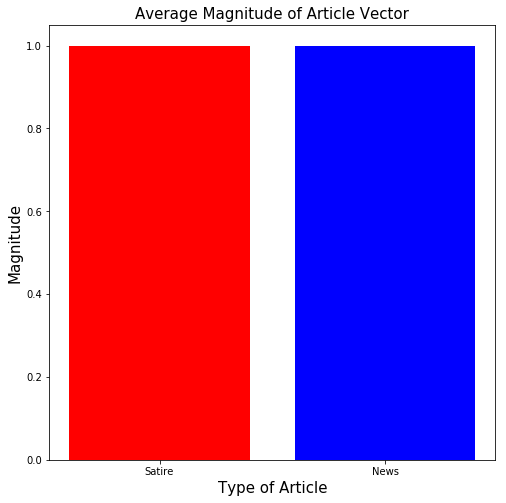

In [115]:
fig, ax = plt.subplots(figsize= (8,8))
plt.bar(['Satire', 'News'],[Satire_mag, News_mag], color ='rby')
ax.set_title("Average Magnitude of Article Vector", fontsize = 15)
ax.set_ylabel("Magnitude", fontsize = 15)
ax.set_xlabel("Type of Article", fontsize = 15)

### SVD

In [59]:
u, s, vt = svds(X_train)

In [62]:
u.shape

(10665, 6)

### Sample Trump Article

In [116]:
sample = 'WASHINGTON—Following the announcement that Homeland Security Secretary Kirstjen Nielsen was leaving her post, President Trump told reporters Monday he would conduct an extensive search to find a replacement with the right personality disorders necessary for the role. “Though I admired Kirstjen’s ability to remain cold and detached when questioned about the decision to tear apart families at the border, we require someone with an even greater lack of empathy to do this job properly,” said the president, who praised Nielsen for putting children in cages but explained that the ideal candidate for the position must possess a degree of psychopathy so severe that they believe no law or moral code of any kind applies to them. “The next person to head the department must be blessed with strong narcissistic tendencies, of course, but also a consistent record of profoundly antisocial behavior. We need someone both spiteful and cruel, but also willing to totally disregard right and wrong. Basically, the new secretary will need to have a psychological makeup that allows them to look people in the eye and tell them, without hesitation, that we don’t want any non-Americans entering the United States unless they’re coming from one of a very limited group of countries in northern Europe.” At press time, a team of psychiatrists had reportedly presented the president with a stack of résumés that consisted solely of individuals housed in supermax prisons and White House senior adviser Stephen Miller.'

In [127]:
def new_cleaner(article_list):
    '''
    Removes more features like punctuation and words that
    should not be in there
    Input: df_final
    output: df_final with cleaned articles
    '''
    #article_list = list(df_final.Article)
    clean_list = []
    #for article in article_list:
    samp1 = re.sub('[''\”\“\‘;:\'\'\'•·%$!&+}{|><_…/\’*0123456789\`]', '', article_list)
    samp2 = re.sub('[-—]', ' ', samp1)
    samp3 = samp2.replace('news','')
    clean_list.append(samp3.replace('fox',''))
    #df['Article'] = clean_list
    return clean_list

In [129]:
clean_sample = new_cleaner(sample)

In [130]:
vect_sample = vect.transform(clean_sample)

In [132]:
log_reg.predict_proba(vect_sample)

array([[0.19972455, 0.80027545]])

In [134]:
log_reg.predict(vect_sample)

array([1])

In [133]:
log_reg.classes_

array([0, 1])